Link dataset https://www.kaggle.com/datasets/jeffheaton/is-a-block-structure-stable-or-unstable

In [1]:
import zipfile
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from PIL import Image
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt



# Caricamento Dataset da Kaggle

In [21]:
!pip install kaggle


In [22]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ProgettoML/kaggle.json"

In [23]:
!kaggle datasets download -d jeffheaton/is-a-block-structure-stable-or-unstable

Traceback (most recent call last):
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/lib/python3.10/site-packages/kaggle/__init__.py", line 3, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/lib/python3.10/site-packages/kaggle/api/__init__.py", line 6, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 258, in <module>
    class KaggleApi(KaggleApi):
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-202

In [24]:


# Define the path to your zip file
file_path = "/content/is-a-block-structure-stable-or-unstable.zip" # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ProgettoML/Dati')  # Replace 'destination_folder' with your desired folder

FileNotFoundError: [Errno 2] No such file or directory: '/content/is-a-block-structure-stable-or-unstable.zip'

# Caricamento dati

In [7]:
import os
import numpy as np
import cv2
from tqdm import tqdm

import os
import numpy as np
import cv2

def load_data(data_dir):
    images = []
    labels = []

    for root, dirs, files in os.walk(data_dir):
        for label_dir in dirs:
            label = os.path.basename(label_dir)
            label_path = os.path.join(root, label_dir)
            print(f"Caricamento della cartella {label}...")
            for image_file in os.listdir(label_path):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(label_path, image_file)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        image = cv2.resize(image, (64, 64))
                        image = image.astype(np.float32) / 255.0
                        images.append(image)
                        labels.append(label)
            print(f"Caricamento della cartella {label} completato.")

    return np.array(images), np.array(labels)

# Esempio di utilizzo della funzione
train_dir = 'percorso/alla/cartella/train'
test_dir = 'percorso/alla/cartella/test'

train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)


# Esempio di utilizzo della funzione
train_dir = 'dataset/asl_alphabet_train'
test_dir = 'dataset/asl_alphabet_test'

train_images, train_labels = load_data(train_dir)
#test_images, test_labels = load_data(test_dir)


Caricamento della cartella asl_alphabet_train...
Caricamento della cartella asl_alphabet_train completato.
Caricamento della cartella R...
Caricamento della cartella R completato.
Caricamento della cartella U...
Caricamento della cartella U completato.
Caricamento della cartella I...
Caricamento della cartella I completato.
Caricamento della cartella N...
Caricamento della cartella N completato.
Caricamento della cartella G...
Caricamento della cartella G completato.
Caricamento della cartella Z...
Caricamento della cartella Z completato.
Caricamento della cartella T...
Caricamento della cartella T completato.
Caricamento della cartella S...
Caricamento della cartella S completato.
Caricamento della cartella A...
Caricamento della cartella A completato.
Caricamento della cartella F...
Caricamento della cartella F completato.
Caricamento della cartella O...
Caricamento della cartella O completato.
Caricamento della cartella H...
Caricamento della cartella H completato.
Caricamento della

In [3]:
train_images.shape

(0,)

In [8]:
from sklearn.model_selection import train_test_split

# Dividi il set di addestramento in train e validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42,stratify=train_labels)

In [9]:
train_images.shape

(69600, 64, 64)

In [ ]:
val_images.shape

(17400, 64, 64)

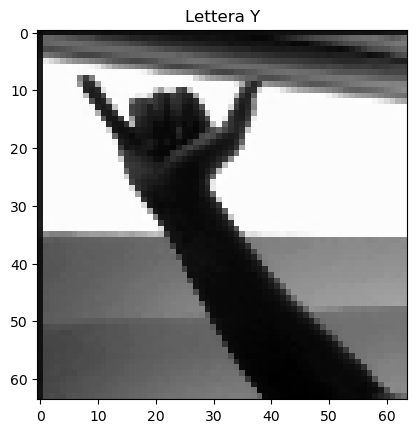

In [ ]:
plt.imshow(train_images[1],cmap="grey")
plt.title(f"Lettera {train_labels[1]}")
plt.show()

# Numpy

In [ ]:
train_images_norm = np.array(train_images)/255

In [15]:
val_images_norm = np.array(val_images)/255

NameError: name 'val_images' is not defined

# Provo a visualizzare i dati 

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [23]:

train_images_norm = np.array(train_images)/255

In [24]:
train_images_vectorized = train_images_norm.reshape(len(train_images_norm), -1)

## Pca

In [27]:
pca = PCA(2)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [28]:
train_pca.shape

(69600, 2)

In [38]:
y_train.shape

(28842,)

In [46]:
train_pca_stable = train_pca[train_labels==1,:]

In [48]:
train_pca_unstable = train_pca[train_labels==0,:]

In [63]:
df = pd.DataFrame(train_pca,columns=["x","y"])

In [64]:
df.shape

(69600, 2)

In [66]:
labels = pd.DataFrame(train_labels,columns=["labels"])

In [67]:
df = pd.concat([df,labels],axis=1)

In [68]:
df.shape

(69600, 3)

In [69]:
df.columns

Index(['x', 'y', 'labels'], dtype='object')

In [71]:
df.head()

,x,y,labels
0,-0.003733,-0.036215,A
1,0.033081,0.021496,Y
2,-0.004233,-0.024579,Z
3,0.021291,0.033344,Z
4,0.018388,0.020552,H


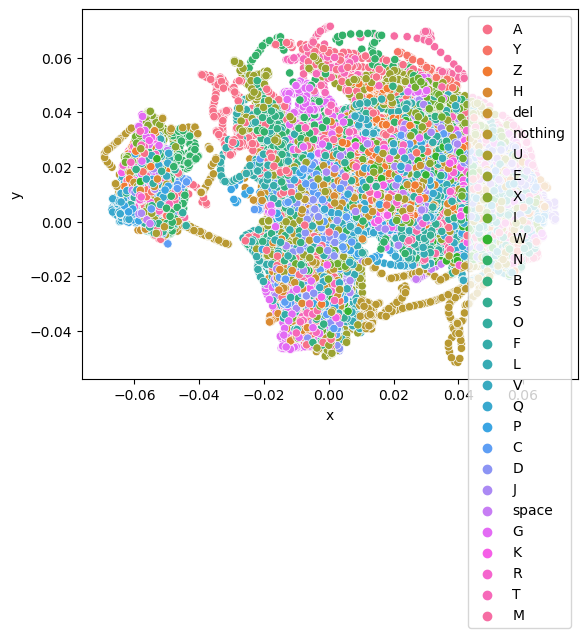

In [72]:
sns.scatterplot(data=df,x="x",y="y", hue='labels')

plt.legend()
plt.show()

## LDA

In [39]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(train_images_vectorized , y_train)

# primo tentativo

In [73]:
import tensorflow as tf
from tensorflow.keras import layers, models

2024-06-08 19:51:24.664133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [117]:
from sklearn.preprocessing import LabelEncoder

# Inizializza il LabelEncoder
label_encoder = LabelEncoder()

# Codifica le etichette di addestramento
train_labels_encoded = label_encoder.fit_transform(train_labels)

In [118]:
model = models.Sequential([
    layers.Flatten(input_shape=(64,64)),  
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [119]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [121]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 12s 7ms/step - loss: 3.1626 - accuracy: 0.1161 - val_loss: 2.9469 - val_accuracy: 0.1654
Epoch 2/100
1740/1740 [==============================] - 12s 7ms/step - loss: 2.8046 - accuracy: 0.1943 - val_loss: 2.6935 - val_accuracy: 0.2180
Epoch 3/100
1740/1740 [==============================] - 12s 7ms/step - loss: 2.5948 - accuracy: 0.2369 - val_loss: 2.5221 - val_accuracy: 0.2503
Epoch 4/100
1740/1740 [==============================] - 11s 7ms/step - loss: 2.4358 - accuracy: 0.2762 - val_loss: 2.3700 - val_accuracy: 0.2899
Epoch 5/100
1740/1740 [==============================] - 11s 7ms/step - loss: 2.3000 - accuracy: 0.3126 - val_loss: 2.2453 - val_accuracy: 0.3219
Epoch 6/100
1740/1740 [==============================] - 11s 7ms/step - loss: 2.1821 - accuracy: 0.3482 - val_loss: 2.1324 - val_accuracy: 0.3601
Epoch 7/100
1740/1740 [==============================] - 13s 8ms/step - loss: 2.0803 - accuracy: 0.3769 - val_loss: 2.0448 -

In [99]:
model.save("./Modelli/modello1")

INFO:tensorflow:Assets written to: ./Modelli/modello1/assets


# Secondo tentativo

In [101]:
from sklearn.decomposition import PCA

In [102]:
train_1d = train_images_norm.reshape(len(train_images_norm), -1)

In [103]:
val_1d = val_images_norm.reshape(len(val_images_norm), -1)

NameError: name 'val_images_norm' is not defined

In [93]:
val_1d.shape

(9615, 5000)

In [104]:
pca = PCA(0.8)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_1d)

In [91]:
val_pca = pca.transform(val_1d)

In [92]:
val_pca.shape

(9615, 11)

In [105]:
model_1 = models.Sequential([
    layers.Dense(11, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [107]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [108]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [112]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.6250 - accuracy: 0.7883 - val_loss: 0.6445 - val_accuracy: 0.7833
Epoch 2/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.6110 - accuracy: 0.7935 - val_loss: 0.6352 - val_accuracy: 0.7824
Epoch 3/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.5937 - accuracy: 0.7979 - val_loss: 0.5932 - val_accuracy: 0.8024
Epoch 4/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.5792 - accuracy: 0.8041 - val_loss: 0.5918 - val_accuracy: 0.7982
Epoch 5/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.5673 - accuracy: 0.8069 - val_loss: 0.6023 - val_accuracy: 0.7889
Epoch 6/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.5509 - accuracy: 0.8118 - val_loss: 0.5609 - val_accuracy: 0.8080
Epoch 7/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.5376 - accuracy: 0.8165 - val_loss: 0.5685 - val_ac

# Tentativo 3

In [55]:
type(train_images[0])

numpy.ndarray

applico un filtro orizziontale

In [129]:
train_images_filtrate_h = [cv2.Sobel(immagine,ddepth=-1,dx=0,dy=1 ) for immagine in train_images]

applico un filtro verticale

In [130]:
train_images_filtrate_v = [cv2.Sobel(immagine,ddepth=-1,dx=1,dy=0 ) for immagine in train_images]

mostro un immagine di test per ciascun filtro

Text(0.5, 1.0, 'Filtro orizzontale')

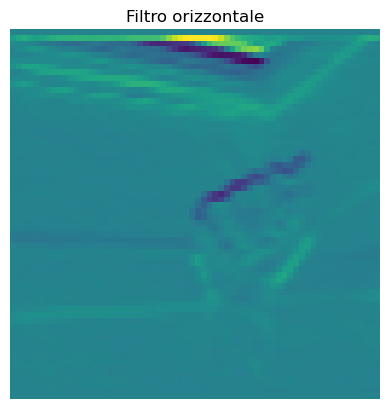

In [131]:
plt.imshow(train_images_filtrate_h[0])
plt.axis(False)
plt.title("Filtro orizzontale")

Text(0.5, 1.0, 'Filtro verticale')

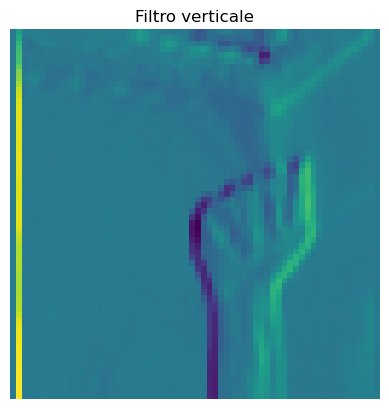

In [132]:
plt.imshow(train_images_filtrate_v[0])
plt.axis(False)
plt.title("Filtro verticale")

combino le immagini

In [133]:
train_images_filtrate = []
for immagine1, immagine2 in zip(train_images_filtrate_v, train_images_filtrate_h):
    # Sovrapponi le immagini (la seconda immagine viene sovrapposta sulla prima)
    combinazione = cv2.addWeighted(immagine1, 0.5, immagine2, 0.5, 0)
    train_images_filtrate.append(combinazione)

Text(0.5, 1.0, 'Filtri combinati')

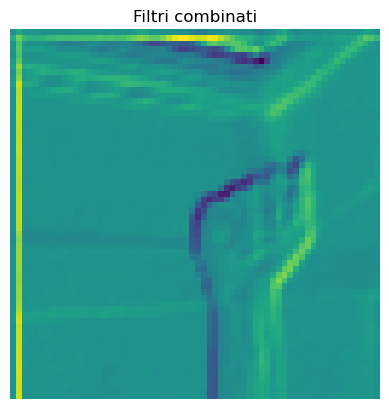

In [134]:
plt.imshow(train_images_filtrate[0])
plt.axis(False)
plt.title("Filtri combinati")

In [239]:
train_images_filtrate[0].shape

(400, 600)

resize per rendere le immagini più gestibili

In [72]:
train_images_filtrate_resize = np.array([cv2.resize(immagine, (150, 100)) for immagine in train_images_filtrate])

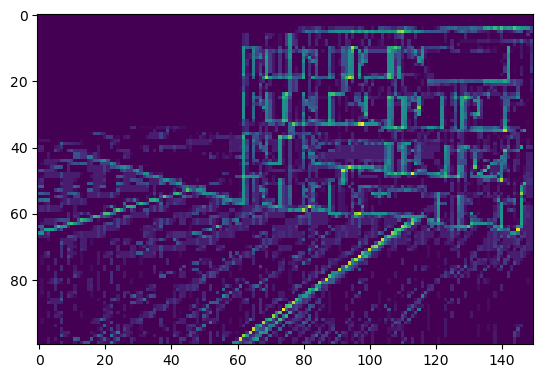

In [73]:
plt.imshow(train_images_filtrate_resize[0])

In [136]:
model_3 = models.Sequential([
    layers.Flatten(input_shape=(64,64)),  
    layers.Dense(256, activation='linear'),
    layers.Dense(29, activation='softmax')
])

In [137]:
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

normalizzo le immagini

In [138]:
train_images_filtrate = np.array(train_images_filtrate)/255

In [139]:
model_3.fit(train_images_filtrate, train_labels_encoded, epochs=30, batch_size=32, validation_split=0.2,callbacks=early_stopping_callback)

Epoch 1/30
1740/1740 [==============================] - 12s 6ms/step - loss: 2.5467 - accuracy: 0.2707 - val_loss: 1.9911 - val_accuracy: 0.4024
Epoch 2/30
1740/1740 [==============================] - 11s 6ms/step - loss: 1.7374 - accuracy: 0.4827 - val_loss: 1.5826 - val_accuracy: 0.5275
Epoch 3/30
1740/1740 [==============================] - 10s 6ms/step - loss: 1.4308 - accuracy: 0.5785 - val_loss: 1.3759 - val_accuracy: 0.5838
Epoch 4/30
1740/1740 [==============================] - 10s 6ms/step - loss: 1.2403 - accuracy: 0.6384 - val_loss: 1.2395 - val_accuracy: 0.6162
Epoch 5/30
1740/1740 [==============================] - 14s 8ms/step - loss: 1.1033 - accuracy: 0.6793 - val_loss: 1.1312 - val_accuracy: 0.6583
Epoch 6/30
1740/1740 [==============================] - 11s 6ms/step - loss: 0.9956 - accuracy: 0.7138 - val_loss: 1.0460 - val_accuracy: 0.6850
Epoch 7/30
1740/1740 [==============================] - 11s 6ms/step - loss: 0.9093 - accuracy: 0.7403 - val_loss: 0.9749 - val_ac

# Tentativo 4

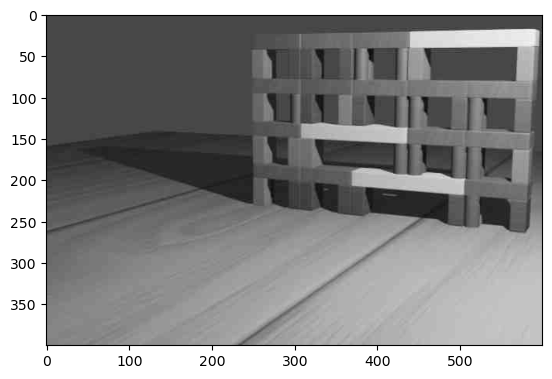

In [39]:
plt.imshow(train_images[0],cmap="grey")

In [40]:
from rembg import remove 



In [41]:
result_image = remove(train_images[0])

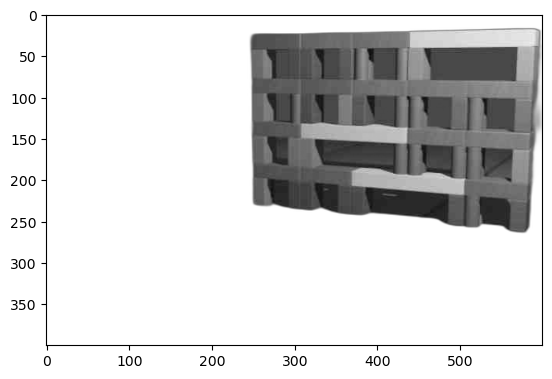

In [42]:
plt.imshow(result_image)

In [43]:
def focusToContent(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_ = 255*(img < 128).astype(np.uint8) 
    coords = cv2.findNonZero(img_) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    rect_originalSized = cv2.resize(rect,(img.shape))
    return rect_originalSized

In [44]:
focused = focusToContent(result_image)

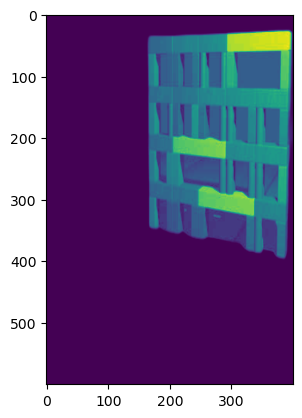

In [45]:
plt.imshow(focused)

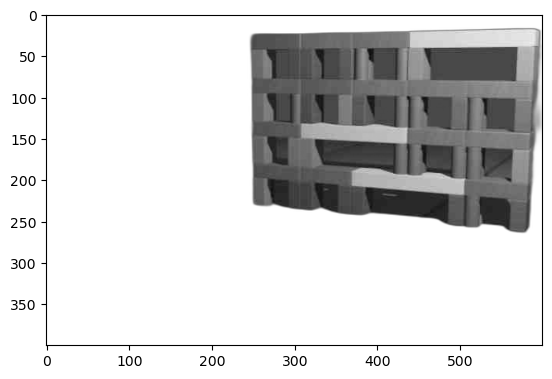

In [46]:
plt.imshow(result_image)

In [47]:
def remove_bg(images):
  image_list =[]
  
  for index in tqdm(range(0,len(images)), desc="Caricamento immagini"):
    
    image_list.append(remove(images[index]))
  return image_list

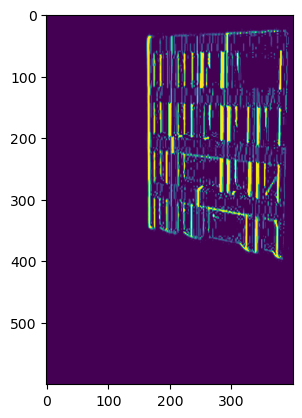

In [48]:
result_image_h = cv2.Scharr(focused,ddepth=-1,dx=1,dy=0 )
plt.imshow(result_image_h)

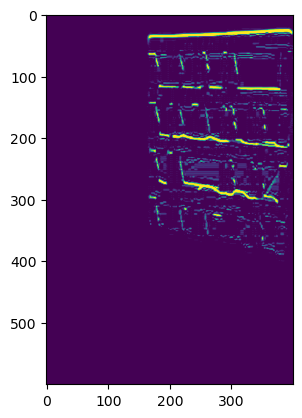

In [49]:
result_image_v = cv2.Scharr(focused,ddepth=-1,dx=0,dy=1 )
plt.imshow(result_image_v)

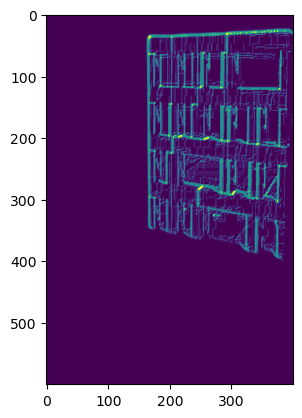

In [50]:
combinazione = cv2.addWeighted(result_image_h, 0.5, result_image_v, 0.5, 0)
plt.imshow(combinazione)

In [51]:
train_images_nobg = remove_bg(train_images)

Caricamento immagini:   0%|          | 25/28842 [00:32<10:26:42,  1.30s/it]


KeyboardInterrupt: 

# CNN

In [124]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_images_norm, train_labels_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping_callback])


Epoch 1/30
1740/1740 [==============================] - 90s 51ms/step - loss: 3.3676 - accuracy: 0.0342 - val_loss: 3.3678 - val_accuracy: 0.0317
Epoch 2/30
1740/1740 [==============================] - 91s 52ms/step - loss: 3.3676 - accuracy: 0.0323 - val_loss: 3.3679 - val_accuracy: 0.0312
Epoch 3/30
1025/1740 [================>.............] - ETA: 35s - loss: 3.3676 - accuracy: 0.0357

KeyboardInterrupt: 

# CNN con filtri

In [61]:
train_images_filtrate_h = [cv2.Scharr(immagine,ddepth=-1,dx=0,dy=1 ) for immagine in train_images]

In [62]:
train_images_filtrate_v = [cv2.Scharr(immagine,ddepth=-1,dx=1,dy=0 ) for immagine in train_images]

In [63]:
train_images_filtrate = []
for immagine1, immagine2 in zip(train_images_filtrate_v, train_images_filtrate_h):
    # Sovrapponi le immagini (la seconda immagine viene sovrapposta sulla prima)
    combinazione = cv2.addWeighted(immagine1, 0.5, immagine2, 0.5, 0)
    train_images_filtrate.append(combinazione)

In [66]:
train_images_resize = np.array([cv2.resize(immagine, (75, 50)) for immagine in train_images_filtrate])
train_images_norm = np.array(train_images_resize)/255
val_images_resize = np.array([cv2.resize(immagine, (75, 50)) for immagine in val_images])
val_images_norm = np.array(val_images_resize)/255

In [111]:
import tensorflow as tf
from tensorflow.keras import layers, models



model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3, 3), activation='relu', input_shape=(50, 75, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(train_images_norm , y_train, epochs=5, batch_size=256,validation_split=0.2)




ValueError: Input 0 of layer "conv3d" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 50, 75, 1)